In [1]:
# IMPORT PACKAGES
import splitfolders
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt 
import os, datetime

In [ ]:
# DATA LOADING 
filepath = r'C:\Users\User\Desktop\AI_ML_TRAINING\YPAI09\Capstone\Capstone 3\Dataset\Raw_data++'
categories = []
for x in os.listdir(filepath):
    categories.append(x)
print(categories)

['Negative', 'Positive']


In [ ]:
splitfolders.ratio(filepath, seed=42, output='C:\Users\User\Desktop\AI_ML_TRAINING\YPAI09\Capstone\Capstone 3\Dataset\Raw_data', ratio=(0.8,0.2))

In [4]:
split_path = r"C:\Users\User\Desktop\AI_ML_TRAINING\YPAI09\Capstone\Capstone 3\Dataset\crack-splitted"

train_dir = os.path.join(split_path, 'train')
validation_dir = os.path.join(split_path, 'val')

BATCH_SIZE = 32 # 32 images for each batch 
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 32000 files belonging to 2 classes.
Found 8000 files belonging to 2 classes.


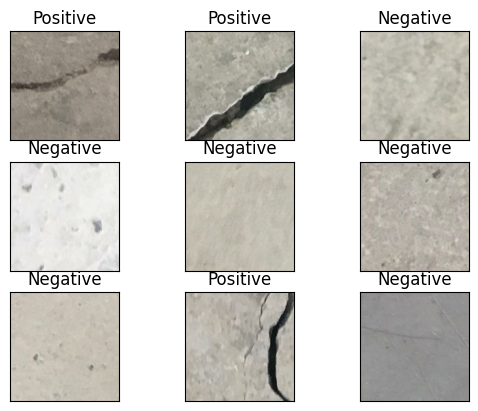

In [5]:
# INSPECT SOME OF THE DATA
class_names = train_dataset.class_names
batch_1 = train_dataset.take(1)
for images,labels in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
plt.show()

In [6]:
# FURTHER SPLIT THE VALIDATION SET INTO VAL-TEST SPLITS
nBatches = validation_dataset.cardinality().numpy() 
val_dataset = validation_dataset.take(nBatches//2)
test_dataset = validation_dataset.skip(nBatches//2)

In [7]:
# CONVERT VAL AND TEST DATASET TO PREFETCH DATASET 
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# CREATE THE DATA AUGMENTATION LAYERS
data_augmentation = keras.Sequential()
data_augmentation.add(keras.layers.RandomFlip('horizontal'))
data_augmentation.add(keras.layers.RandomRotation(0.2))

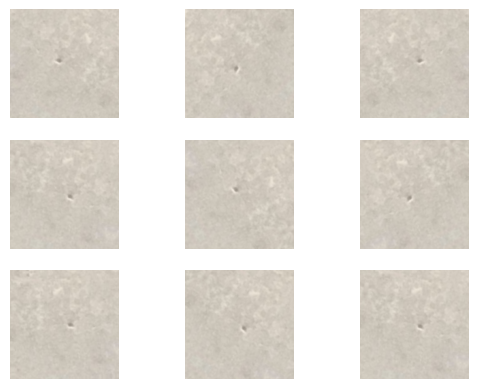

In [9]:
# LET'S TEST OUT THE DATA AUGMENTATION LAYERS
for images,labels in train_dataset.take(1):
    first_image = images[0]
    plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,axis=0))
        plt.imshow(augmented_image[0]/255.0) # display image in uint8 or normalized pixel value
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
plt.show()

In [10]:
# CREATE THE PREPROCESS INPUT LAYER FOR mobilenet_v2 
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [11]:
# PERFORM TRANSFER LEARNING
# (A) Create the feature extractor from the pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet') # what we can modify: input_shape, include_top, weights
# Freeze the entire base model so that it will not receive any training (non-trainable)
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# (B) Add in our own classifier
global_avg = keras.layers.GlobalAveragePooling2D() # will serve as flatten layer
output_layer = keras.layers.Dense(len(class_names),activation='softmax')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

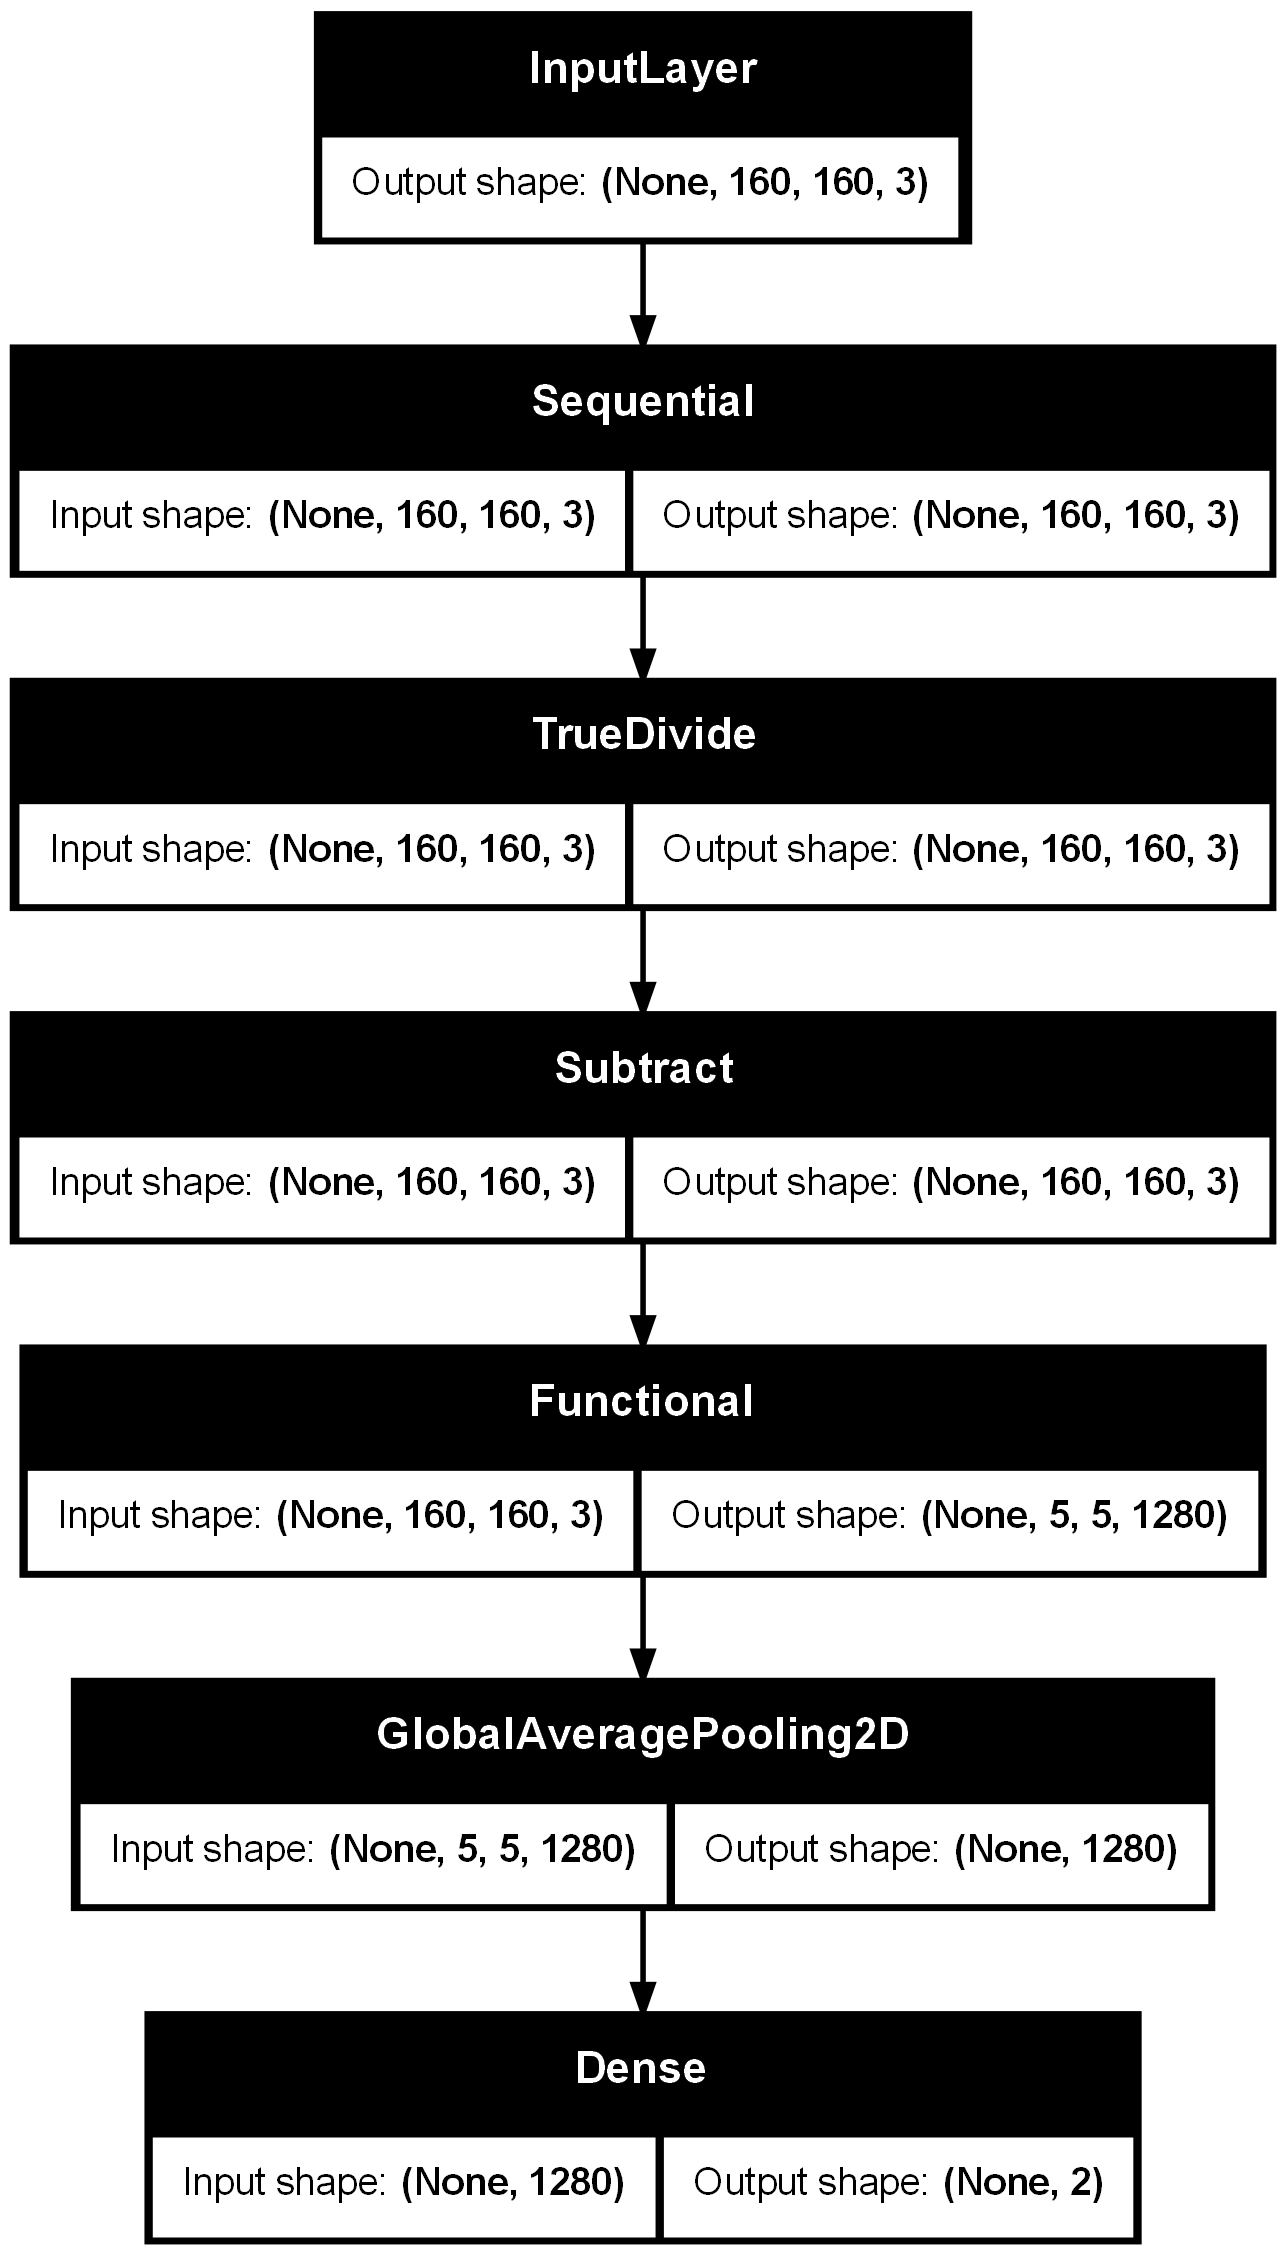

In [13]:
# (C) Use functionalAPI to connect the layers together to form a pipeline 
# a. Begin with input
inputs = keras.Input(shape=IMG_SHAPE)
# b. Augmentation
x = data_augmentation(inputs)
# c. Preprocess layer
x = preprocess_input(x)
# d. Feature extractor
x = base_model(x)
# e. Classifier
x = global_avg(x)
outputs = output_layer(x)

model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()
keras.utils.plot_model(model,show_shapes=True)

In [14]:
# MODEL COMPILE
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
# Define the callbacks
logpath = "tensorboard/concrete_crack/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)
es = keras.callbacks.EarlyStopping(patience=3,verbose=1)

In [16]:
# Evaluate the model before training
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.4469 - loss: 0.9204


[0.9120724201202393, 0.44699999690055847]

In [17]:
# FIRST STAGE OF TRAINING 
EPOCHS = 10
history_first = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=EPOCHS,
                        callbacks=[tb,es])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 132s 129ms/step - accuracy: 0.9342 - loss: 0.1723 - val_accuracy: 0.9960 - val_loss: 0.0159
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 139s 139ms/step - accuracy: 0.9973 - loss: 0.0112 - val_accuracy: 0.9977 - val_loss: 0.0106
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 142ms/step - accuracy: 0.9984 - loss: 0.0075 - val_accuracy: 0.9975 - val_loss: 0.0101
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 140s 140ms/step - accuracy: 0.9980 - loss: 0.0067 - val_accuracy: 0.9980 - val_loss: 0.0087
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 140s 140ms/step - accuracy: 0.9982 - loss: 0.0058 - val_accuracy: 0.9977 - val_loss: 0.0096
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 148s 148ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9980 - val_loss: 0.0082
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 147s 147ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9977 - val_loss: 0.0094
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 147s 147ms/step - ac

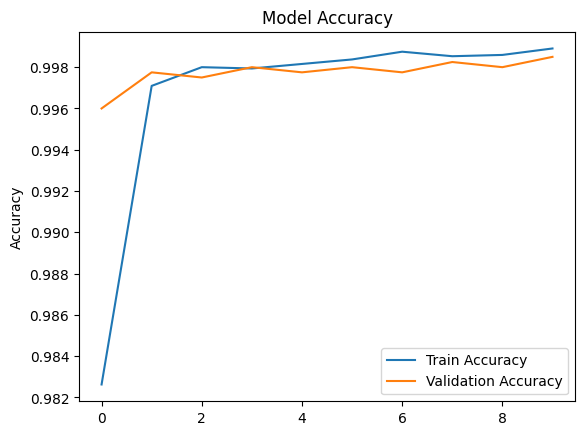

In [18]:
# Plot Accuracy Graph
plt.plot(history_first.history['accuracy'], label='Train Accuracy')
plt.plot(history_first.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.legend()  
plt.show()

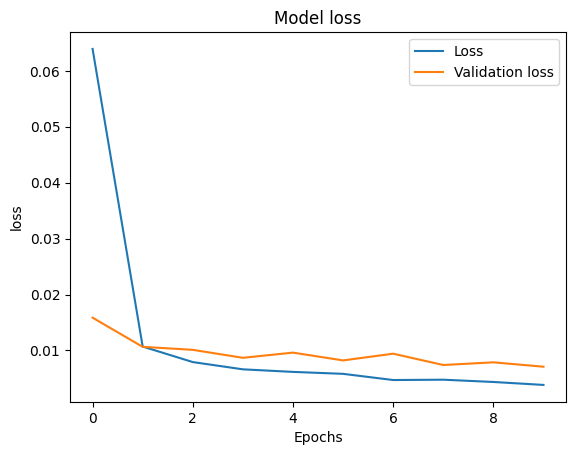

In [19]:
# Plot Loss Graph
plt.plot(history_first.history['loss'], label='Loss')
plt.plot(history_first.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
# if validation higher than loss, overfitting

In [20]:
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.9989 - loss: 0.0043


[0.008320407941937447, 0.9972500205039978]

In [21]:
# PROCEED WITH SECOND STAGE OF TRAINING
# (A) Unfreeze the base model
base_model.trainable = True
# (B) Freeze the earlier layers inside the base model
fine_tune_at = 100
for layer in base_model.layers[:100]:
    layer.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [22]:
# Recompile the model, this time we will choose a different optimizer
rms = keras.optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
# (C) Run the second stage of training
fine_tune_epoch = 10
total_epoch = EPOCHS + fine_tune_epoch
history_fine = model.fit(train_dataset,validation_data=validation_dataset,epochs=total_epoch,initial_epoch=len(history_first.epoch),callbacks=[tb])

Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 245s 234ms/step - accuracy: 0.9670 - loss: 0.0875 - val_accuracy: 0.9962 - val_loss: 0.0122
Epoch 12/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 209s 209ms/step - accuracy: 0.9959 - loss: 0.0121 - val_accuracy: 0.9980 - val_loss: 0.0071
Epoch 13/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 219s 219ms/step - accuracy: 0.9971 - loss: 0.0094 - val_accuracy: 0.9981 - val_loss: 0.0055
Epoch 14/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 202s 202ms/step - accuracy: 0.9980 - loss: 0.0055 - val_accuracy: 0.9985 - val_loss: 0.0052
Epoch 15/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 222s 223ms/step - accuracy: 0.9982 - loss: 0.0053 - val_accuracy: 0.9984 - val_loss: 0.0062
Epoch 16/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - accuracy: 0.9988 - loss: 0.0042 - val_accuracy: 0.9986 - val_loss: 0.0055
Epoch 17/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 0.9987 - val_loss: 0.0048
Epoch 18/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 241s 241ms/s

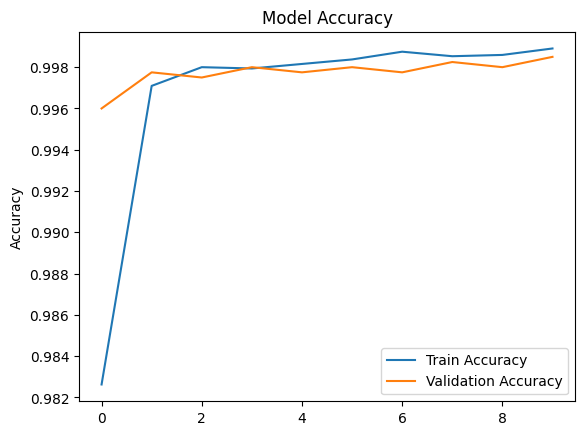

In [24]:
# Plot Accuracy Graph
plt.plot(history_first.history['accuracy'], label='Train Accuracy')
plt.plot(history_first.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.legend()  
plt.show()

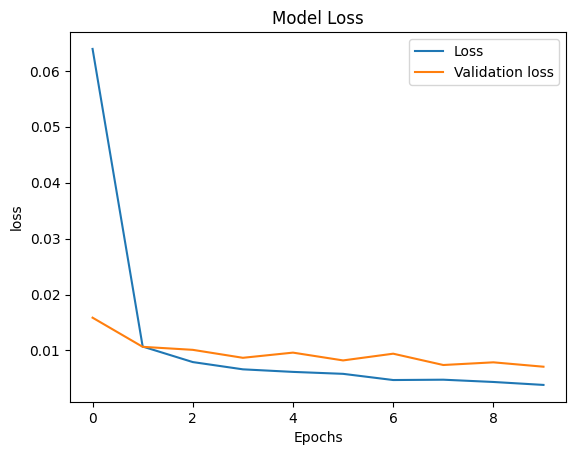

In [25]:
# Plot Loss Graph
plt.plot(history_first.history['loss'], label='Loss')
plt.plot(history_first.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
# if validation higher than loss, overfitting

In [26]:
# Evaluate model after training using test dataset 
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9977 - loss: 0.0052


[0.004150608088821173, 0.9982500076293945]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
['Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive']
[0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


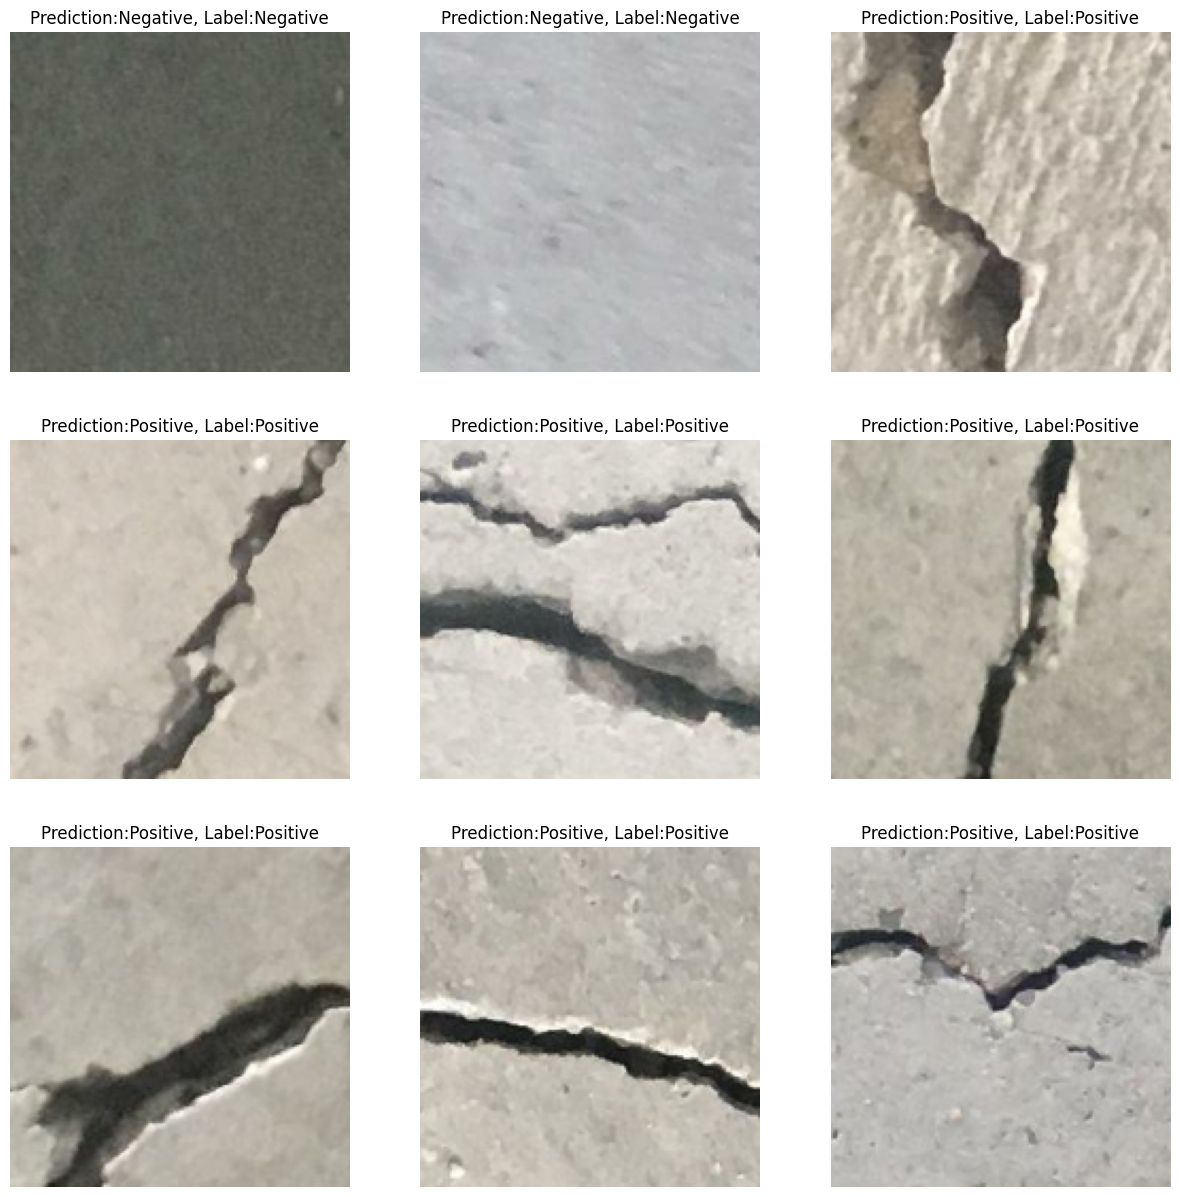

In [27]:
# Predictions with the test data

for image_batch, labels_batch in test_dataset.take(1):
    predictions =np.argmax(model.predict(image_batch), axis=1)
    predicted_class =[class_names[x] for x in predictions]

print(predicted_class) #list of comprehension of predicted class
print(predictions)

plt.figure(figsize=(15,15))
for i in range (9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'Prediction:{predicted_class[i]}, Label:{class_names[labels_batch[i]]}')
plt.show()

In [28]:
# Save model

keras.models.save_model(model,"Model/concrete_crack_detection.h5")